# Discrete examples

In [125]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, time
sys.path.insert(1, '../discrete_mixflows/')
from discrete_mixflows import *
from gibbs import *
from concrete import *

plt.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams["figure.figsize"]=15,7.5
plt.rcParams.update({'font.size': 24})

## 1D toy example

First we generate a one-dimensional synthetic example
where $\pi$ is a distribution over $\{1,\dots,10\}$.
We approximate $\pi$ with a MAD Mix $q_N$
of depth $N=500$ and with a uniform reference 
$q_0\sim\mathsf{U}\{1,\dots10\}$.
We also target $\pi$ with a standard Gibbs sampler
run for 50,000 iterations, where only the last 500 are kept.

Below we show a plot of the exact density $q_N(x)$ compared to $\pi(x)$,
along with a histogram of samples from the Gibbs sampler.

In [41]:
########################
########################
# target specification #
########################
########################
np.random.seed(2023)
K1=10
prbs=np.random.rand(K1)
prbs=prbs/np.sum(prbs)
def lp(x,axis=None):
    # compute the univariate log joint and conditional target pmfs
    #
    # inputs:
    #    x    : (1,d) array with state values
    #    axis : int, full conditional to calculate; returns joint if None
    # outputs:
    #   ext_lprb : if axis is None, (d,) array with log joint; else, (d,K1) array with d conditionals 
    
    ext_lprb=np.log(np.repeat(prbs[:,np.newaxis],x.shape[1],axis=1).T)
    if axis==None: return np.squeeze(ext_lprb[np.arange(0,x.shape[1]),x])
    return ext_lprb

In [42]:
########################
########################
#    MAD Mix approx    #
########################
########################

# reference specification
lq0 = lambda x,u : np.log(1/K1)*np.ones(x.shape[1])
def randq0(size): return np.random.randint(0,K1,size).reshape(1,size),np.random.rand(1,size)

N=500 # number of steps in qN
xi=np.pi/16

# evaluate density
x=np.array(np.arange(0,K1)[np.newaxis,:],dtype=int)
u=np.random.rand(1,K1)
qvar=np.exp(lqN(x,u,N,lq0,lp,xi))

In [43]:
########################
########################
#    Gibbs sampling    #
########################
########################
np.random.seed(2023)
x0=np.random.randint(low=0,high=K1)*np.ones(1)
gibbs_samples=gibbs_sampler(x0=x0,steps=N,lp=lp,burnin_pct=0.99,verbose=True)

In [79]:
########################
########################
#    Concrete          #
########################
########################
print('Training Concrete with low temperature')
concrete_low,cl_loss=trainRealNVP(temp=0.1,depth=10,lprbs=np.log(prbs),layers=256,max_iters=3001,lr=5*1e-3,seed=2023)

Training Concrete with low temperature
iter 0: loss = 870.710
iter 300: loss = 33.345
iter 600: loss = 31.955
iter 900: loss = 31.584
iter 1200: loss = 29.265
iter 1500: loss = 28.805
iter 1800: loss = 27.808
iter 2100: loss = 28.261
iter 2400: loss = 27.917
iter 2700: loss = 30.641
iter 3000: loss = 26.985


In [126]:
########################
########################
#    Concrete          #
########################
########################
from IPython.display import clear_output

# TIME SUNK!!! RUN AT YOUR OWN PERIL
# simulation settings:
max_iters = 10#100001
temps     = np.array([0.1,0.5,1,5])
depths    = np.array([10,50,100])
layers    = np.array([32,64,128,256,512])
sim_size  = temps.shape[0]*depths.shape[0]*layers.shape[0]
flows     = [0 for i in range(sim_size)]
losses    = np.zeros((sim_size,max_iters))
cpu_times = np.zeros(sim_size)
i=0

print('Training '+str(sim_size)+' flows')
for temp in temps:
    for depth in depths:
        for width in layers:
            print('Training flow '+str(i+1)+'/'+str(sim_size))
            print('Temperature: '+str(temp))
            print('Depth: '+str(depth))
            print('Width: '+str(width))
            t0 = time.perf_counter()
            tmp_flow,tmp_loss=trainRealNVP(
                temp=temp,depth=depth,lprbs=np.log(prbs),layers=layer,max_iters=max_iters,lr=1e-3,seed=2023
            )
            cpu_times[i]=time.perf_counter()-t0
            flows[i]=tmp_flow
            losses[i,:]=tmp_loss
            clear_output(wait=True)
            i=i+1
        # end for
    # end for
# end for
clear_output(wait=True)
print('Done!')
print('Total training time: '+str(cpu_times.sum())+' seconds')

Done!


In [ ]:
threshold=100
for i in range(sim_size): plt.plot(np.arange(max_iters)[losses[i,:]<threshold],losses[i,losses[i,:]<threshold],'-k',alpha=0.5)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Concrete RealNVP training loss traceplots')

In [94]:
print('Training Concrete with low temperature')
concrete_low,cl_loss=trainRealNVP(temp=1.,depth=50,lprbs=np.log(prbs),layers=32,max_iters=3001,lr=1e-3,seed=2023)

Training Concrete with low temperature
iter 0: loss = 498783.250
iter 300: loss = 19.522


KeyboardInterrupt: 

In [96]:
print('Training Concrete with high temperature')
concrete_high,ch_loss=trainRealNVP(temp=5.,depth=10,lprbs=np.log(prbs),layers=32,max_iters=3001,lr=1e-3,seed=2023)

Training Concrete with high temperature
iter 0: loss = 112.170
iter 300: loss = -0.469
iter 600: loss = -2.462
iter 900: loss = -3.496
iter 1200: loss = -1.608
iter 1500: loss = -2.105
iter 1800: loss = -2.892
iter 2100: loss = -4.430
iter 2400: loss = -4.856
iter 2700: loss = -2.227
iter 3000: loss = -3.482


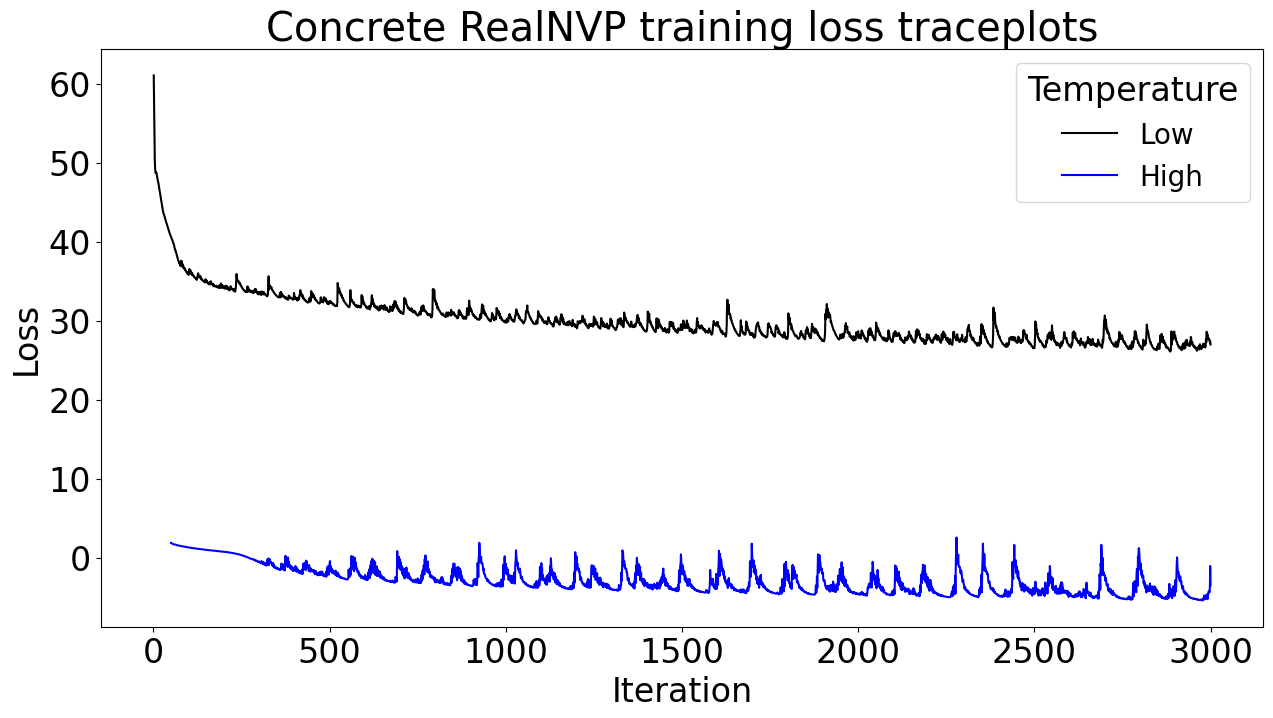

In [97]:
plt.plot(np.arange(cl_loss.shape[0])[cl_loss<100],cl_loss[cl_loss<100],'-k',label='Low')
plt.plot(np.arange(ch_loss.shape[0])[50:],ch_loss[50:],'-b',label='High')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Concrete RealNVP training loss traceplots')
plt.legend(title='Temperature',fontsize='small')

In [98]:
# get Concrete samples
cl_samples=concrete_low.sample(10000)
cl_samples=np.exp(np.squeeze(cl_samples.detach().numpy()))
cl_samples=cl_samples/np.sum(cl_samples,axis=-1)[:,np.newaxis]
cl_samples=np.argmax(cl_samples,axis=-1)

ch_samples=concrete_high.sample(10000)
ch_samples=np.exp(np.squeeze(ch_samples.detach().numpy()))
ch_samples=ch_samples/np.sum(ch_samples,axis=-1)[:,np.newaxis]
ch_samples=np.argmax(ch_samples,axis=-1)

In [99]:
########################
########################
#  estimate densities  #
########################
########################
gibbs_density=plt.hist(gibbs_samples[0,:],density=True,bins=np.arange(0,K1+1))[0]
cl_density=plt.hist(cl_samples,density=True,bins=np.arange(0,K1+1))[0]
ch_density=plt.hist(ch_samples,density=True,bins=np.arange(0,K1+1))[0]+1e-32
plt.clf()

<Figure size 1500x750 with 0 Axes>

In [100]:
########################
########################
#    compute elbos     #
########################
########################
elbo_qN=elbo_exact(np.log(qvar/np.sum(qvar)),np.log(prbs))
elbo_gibbs=elbo_exact(np.log(gibbs_density),np.log(prbs))
elbo_cl=elbo_exact(np.log(cl_density),np.log(prbs))
elbo_ch=elbo_exact(np.log(ch_density),np.log(prbs))
print('ELBO(qN||π)='+str(elbo_qN))
print('ELBO(qGibbs||π)='+str(elbo_gibbs))
print('ELBO(qConcrete_low||π)='+str(elbo_cl))
print('ELBO(qConcrete_high||π)='+str(elbo_ch))

ELBO(qN||π)=-0.00040329033243014217
ELBO(qGibbs||π)=-0.002063302048339602
ELBO(qConcrete_low||π)=-0.2332034755273143
ELBO(qConcrete_high||π)=-0.40239045183017846


Text(0, 0.5, 'probability')

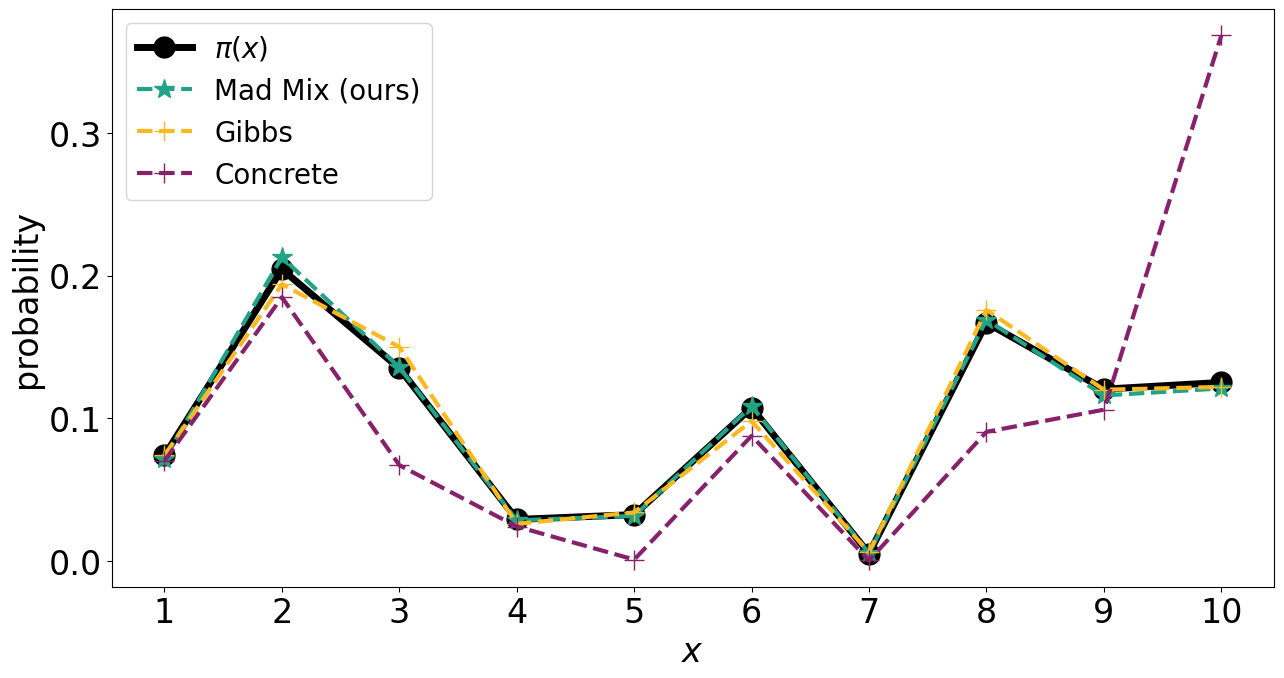

In [104]:
########################
########################
#     plot results     #
########################
########################

ttx=np.arange(0,K1)
plt.plot(ttx+0.5,prbs,c="black", label=r'$\pi(x)$',lw=5,ms=15,marker='o')
plt.plot(ttx+0.5,qvar/np.sum(qvar),c='#20A386FF', label='Mad Mix (ours)',lw=3,ls='dashed',ms=15,marker='*')
plt.plot(ttx+0.5,gibbs_density,c='#FBB91FFF', label='Gibbs',lw=3,ls='dashed',ms=15,marker='+')
plt.plot(ttx+0.5,cl_density,c='#87216BFF', label='Concrete',lw=3,ls='dashed',ms=15,marker='+')
#plt.plot(ttx+0.5,ch_density,c='#E55C30FF', label='Concrete (high)',lw=3,ls='dashed',ms=15,marker='+')
plt.legend(fontsize='small')
plt.xlabel(r'$x$')
plt.xticks(ticks=np.arange(0,K1)+0.5,labels=np.arange(1,1+K1))
plt.ylabel('probability')

Text(0, 0.5, 'probability')

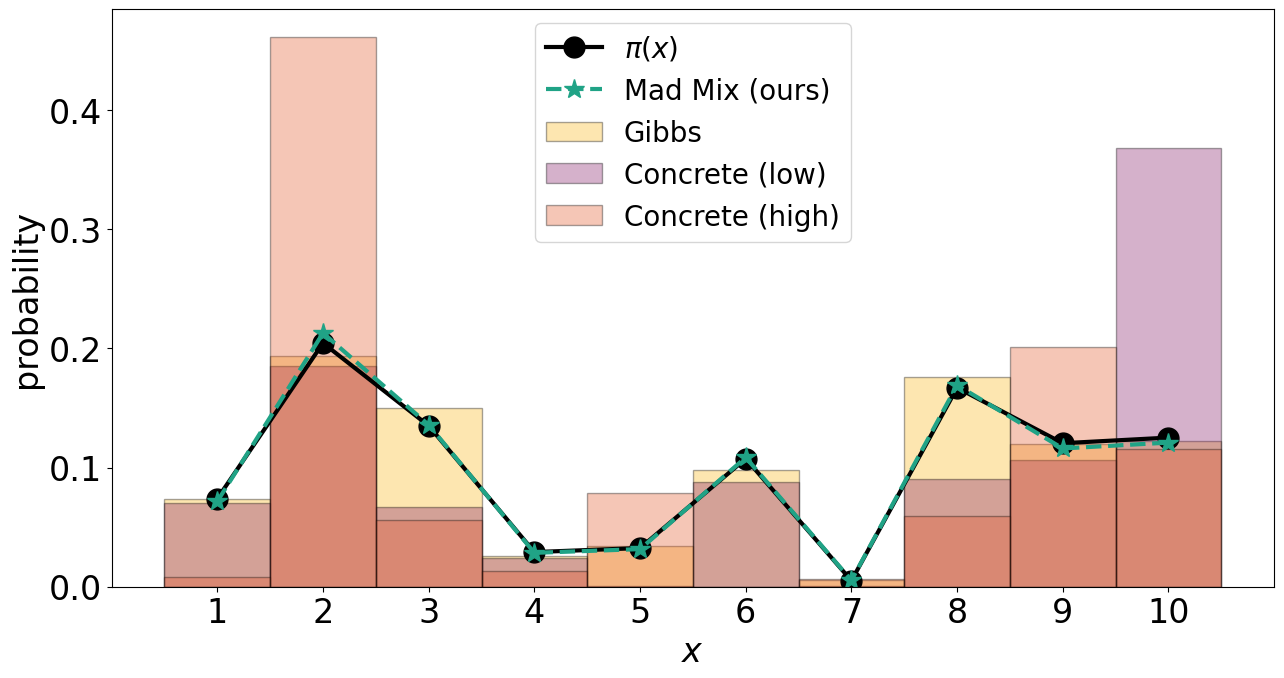

In [102]:
########################
########################
#     plot results     #
########################
########################

ttx=np.arange(0,K1)
plt.plot(ttx+0.5,prbs,c="black", label=r'$\pi(x)$',lw=3,ms=15,marker='o')
plt.plot(ttx+0.5,qvar/np.sum(qvar),c='#20A386FF', label='Mad Mix (ours)',lw=3,ls='dashed',ms=15,marker='*')
plt.hist(gibbs_samples[0,:],density=True,bins=np.arange(0,K1+1),
         alpha=0.35, label='Gibbs', color="#FBB91FFF",ec='black')
plt.hist(cl_samples,density=True,bins=np.arange(0,K1+1),
         alpha=0.35, label='Concrete (low)', color="#87216BFF",ec='black')
plt.hist(ch_samples,density=True,bins=np.arange(0,K1+1),
         alpha=0.35, label='Concrete (high)', color="#E55C30FF",ec='black')
plt.legend(fontsize='small')
plt.xlabel(r'$x$')
plt.xticks(ticks=np.arange(0,K1)+0.5,labels=np.arange(1,1+K1))
plt.ylabel('probability')

## 2D toy example

Now we generate a two-dimensional synthetic example
where $\pi$ is a distribution over 
$\mathcal{X}=\{1,\dots,4\}\times\{1,\dots,5\}$.
We approximate $\pi$ with a MAD Mix $q_N$
of depth $N=500$ and with a uniform reference 
$q_0\sim\mathsf{U}(\mathcal{X})$.
We also target $\pi$ with a standard Gibbs sampler
run for 50,000 iterations, where only the last 500 are kept.

Below we show plots of the exact marginal densities $q_N(x_m)$ compared to $\pi(x_m)$,
$m=1,2$, along with a corresponding histogram of samples from the Gibbs sampler.

In [7]:
########################
########################
# target specification #
########################
########################
np.random.seed(2023)
K1=4
K2=5
prbs=np.random.rand(K1,K2)
prbs=prbs/np.sum(prbs)
def lp(x,axis=None):
    # compute the univariate log joint and conditional target pmfs
    #
    # inputs:
    #    x    : (2,d) array with state values
    #    axis : int, full conditional to calculate; returns joint if None
    # outputs:
    #   ext_lprb : if axis is None, (d,) array with log joint; else, (d,K_{axis+1}) array with d conditionals 
    
    ext_lprb=np.log(np.moveaxis(np.repeat(prbs[:,:,np.newaxis],x.shape[1],axis=-1),2,0)) # stack d copies of logp vertically
    if axis==None: return np.squeeze(ext_lprb[np.arange(0,x.shape[1]),x[0,:],x[1,:]]) # for each d, return lp(x)
    if axis==0: return ext_lprb[np.arange(0,x.shape[1]),:,x[1,:]]
    if axis==1: return ext_lprb[np.arange(0,x.shape[1]),x[0,:],:]
    raise Exception("Axis out of bounds - there aren't that many variables")

In [8]:
########################
########################
#    MAD Mix approx    #
########################
########################

# reference specification
lq0 = lambda x,u : -np.log(K1*K2)*np.ones(x.shape[1])
def randq0(size): return np.vstack((np.random.randint(0,K1,size),np.random.randint(0,K2,size))).T,np.random.rand(size,size)

N=500 # number of steps in qN
xi=np.pi/16

# evaluate density
# first create a grid of values of x1 and x2
# adapted from https://stackoverflow.com/questions/27286537/numpy-efficient-way-to-generate-combinations-from-given-ranges
x = np.mgrid[0:K1,0:K2] 
x = np.rollaxis(x, 0, 3)
x = x.reshape((K1*K2,2)).T
myx=np.copy(x)
# now sample u and evaluate density
u=np.random.rand(2,K1*K2)
qvar=np.exp(lqN(x,u,N,lq0,lp,xi))
myqvar=qvar.reshape(prbs.shape) # to move back from (K1*K2,) to (K1,K2) array

In [9]:
########################
########################
#    Gibbs sampling    #
########################
########################
np.random.seed(2023)
x0=np.array([np.random.randint(low=0,high=K1),np.random.randint(low=0,high=K2)])
gibbs_samples=gibbs_sampler(x0=x0,steps=N,lp=lp,burnin_pct=0.99,verbose=True)

Text(0, 0.5, 'probability')

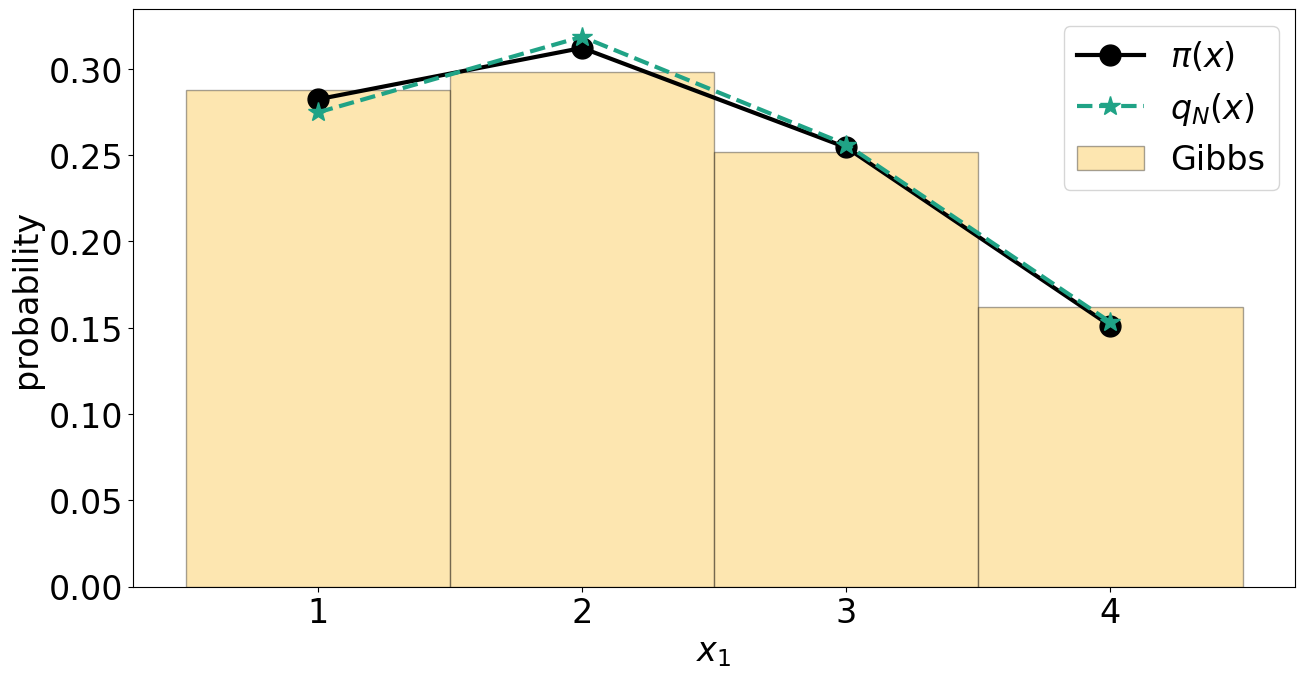

In [10]:
########################
########################
#   plot x1 results    #
########################
########################

ttx=np.arange(0,K1)
plt.plot(ttx+0.5,np.sum(prbs,axis=1),c="black", label=r'$\pi(x)$',lw=3,ms=15,marker='o')
plt.plot(ttx+0.5,np.sum(myqvar,axis=1),c='#20A386FF', label=r'$q_N(x)$',lw=3,ls='dashed',ms=15,marker='*')
plt.hist(gibbs_samples[0,:],density=True,bins=np.arange(0,K1+1),
         alpha=0.35, label='Gibbs', color="#FBB91FFF",ec='black')
plt.legend()
plt.xlabel(r'$x_1$')
plt.xticks(ticks=np.arange(0,K1)+0.5,labels=np.arange(1,1+K1))
plt.ylabel('probability')

Text(0, 0.5, 'probability')

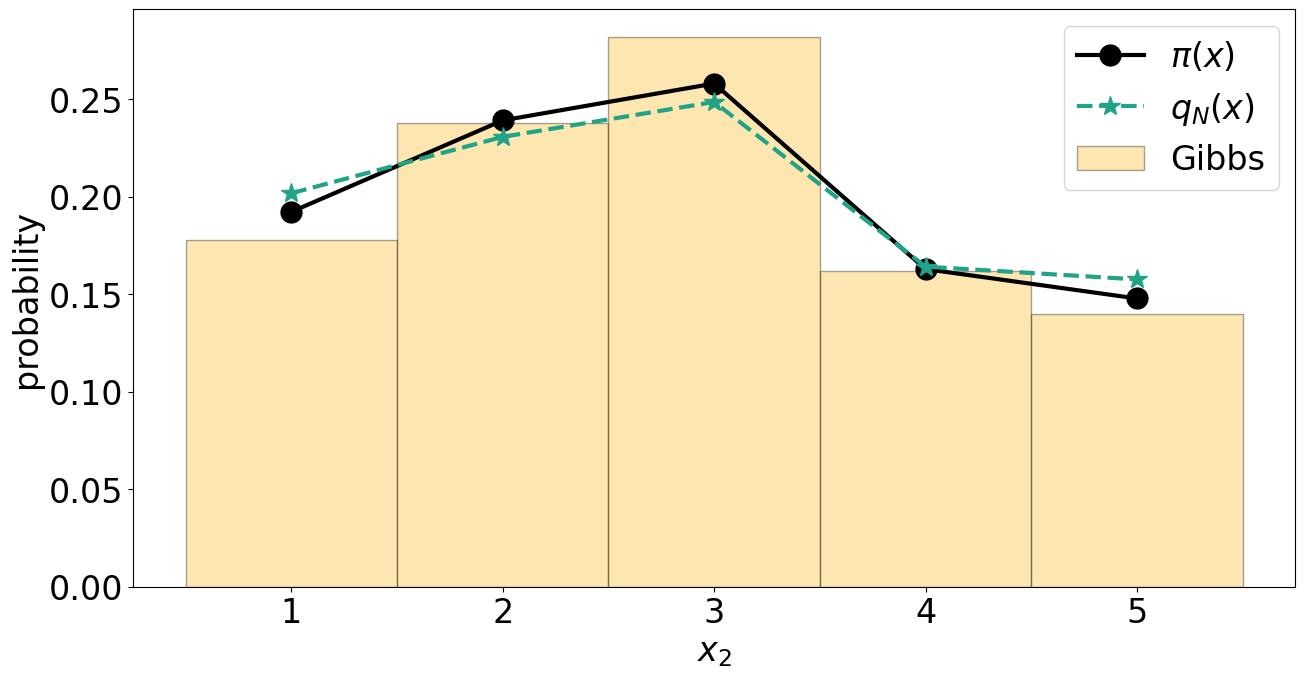

In [11]:
########################
########################
#   plot x2 results    #
########################
########################

ttx=np.arange(0,K2)
plt.plot(ttx+0.5,np.sum(prbs,axis=0),c="black", label=r'$\pi(x)$',lw=3,ms=15,marker='o')
plt.plot(ttx+0.5,np.sum(myqvar,axis=0),c='#20A386FF', label=r'$q_N(x)$',lw=3,ls='dashed',ms=15,marker='*')
plt.hist(gibbs_samples[1,:],density=True,bins=np.arange(0,K2+1),
         alpha=0.35, label='Gibbs', color="#FBB91FFF",ec='black')
plt.legend()
plt.xlabel(r'$x_2$')
plt.xticks(ticks=np.arange(0,K2)+0.5,labels=np.arange(1,1+K2))
plt.ylabel('probability')

In [12]:
gibbs_density=plt.hist2d(gibbs_samples[0,:],gibbs_samples[1,:],density=True,
                         bins=[np.arange(0,K1+1),np.arange(0,K2+1)],
                         alpha=0.35, label='Gibbs', color="#FBB91FFF",ec='black')[0]
plt.clf()
elbo_qN=elbo_exact(np.log(myqvar/np.sum(myqvar)),np.log(prbs))
elbo_gibbs=elbo_exact(np.log(gibbs_density),np.log(prbs))
print('ELBO(qN||π)='+str(elbo_qN))
print('ELBO(qGibbs||π)='+str(elbo_gibbs))

ELBO(qN||π)=-0.002000021625141389
ELBO(qGibbs||π)=-0.012151424983941169


<Figure size 1500x750 with 0 Axes>

## Bimodal example

We finally consider a 2D bimodal example.
Specifically,
let $X_2|X_1=x$ be a discretized Gaussian on $\{1,\dots,20\}$ 
with mean $\mu_x$ and unit variance,
where $X_1\sim\mathsf{Unif}\{0,1\}$ and $\mu_0=4,\mu_1=15$.
Hence $\mathbb{P}(X_2=n\,|\,X_1=x)\propto\phi(n-\mu_x)$, $n\in[20], x=0,1$,
where $\phi$ is the pdf of a standard Gaussian.

A standard Gibbs sampler initialized at the first mode will get stuck:
moving only along $x_2$ is a highly unlikely proposal since
it corresponds to the probability of observing a tail value under the second mode.
An analogous argument applies to a sampler initialized at the second mode.

In the case of Mad Mix, we can leverage the fact that we can estimate the ELBO
to optimally weight two different flows, each initialized in a different mode.
That is, we consider a variational proposal of the form
$$
    q_N=wq_{N,0}+(1-w)q_{N,1},
$$
where $w\in(0,1)$ and $q_{N,i}=\frac{1}{N}\sum_{n=0}^{N-1} T^n q_i$
and $q_i$ is a distribution that covers mode $i$, $i=0,1$.
We then select
$$
    w=\arg\min_{\alpha\in(0,1)}
    \mathrm{D}_{\mathrm{KL}}
    (\alpha q_{N,0}+(1-\alpha)q_{N,1}\,||\,\pi),
$$
which can be estimated via gradient descent since
$$
    \frac{\mathrm{d}}{\mathrm{d}\alpha}
    \alpha q_{N,0}+(1-\alpha)q_{N,1}
    =\mathbb{E}_{q_{N,0}}
    \left[\log\frac{\alpha q_{N,0}+(1-\alpha)q_{N,1}}{\pi}\right]
    -\mathbb{E}_{q_{N,1}}
    \left[\log\frac{\alpha q_{N,0}+(1-\alpha)q_{N,1}}{\pi}\right].
$$

Below we run Gibbs sampler for 50,000 iterations (saving only the last 500)
and then show the density of each $q_{N,i}$.
Then we optimize $w$ and compare the density of $q_N$
with the results from the Gibbs sampler.

In [13]:
########################
########################
# target specification #
########################
########################
eps=1e-16
mu=np.array([4,15]) # the two modes
def aux_gausslp(aux): return -0.5*(np.arange(0,20)-mu[aux][:,np.newaxis])**2-0.5*np.log(2*np.pi)
def aux_gausslp_1d(y,x): return -0.5*(y-mu[x])**2-0.5*np.log(2*np.pi)

def lp(x,axis=None):
    # compute the univariate log joint and conditional target pmfs
    #
    # inputs:
    #    x    : (2,d) array with state values
    #    axis : int, full conditional to calculate; returns joint if None
    # outputs:
    #   ext_lprb : if axis is None, (d,) array with log joint; else, (d,K_{axis+1}) array with d conditionals 
    
    y=x[0,:]
    aux=x[1,:]
    
    if axis==None: return -0.5*(y-mu[aux])**2-0.5*np.log(2*np.pi)#1.
    if axis==0: return aux_gausslp(aux)
    if axis==1: 
        wlpy0=aux_gausslp_1d(y,0)+np.log(0.5)
        wlpy1=aux_gausslp_1d(y,1)+np.log(0.5)
        m=np.maximum(wlpy0,wlpy1)
        lpy=m+np.log(np.exp(wlpy0-m)+np.exp(wlpy1-m))
        #out=np.log1p(-eps)*np.ones((y.shape[0],2))
        #out[y>=10,0]=np.log(eps)
        #out[y<10,1]=np.log(eps)
        #out=0.5*np.ones((y.shape[0],2))
        out=np.ones((y.shape[0],2))
        out[:,0]=wlpy0
        out[:,1]=wlpy1
        return out-lpy[:,np.newaxis]
    raise Exception("Axis out of bounds - there aren't that many variables")

In [14]:
########################
########################
#    MAD Mix approx    #
########################
########################

# reference specification
def lq0_0(x,u):
    out=-0.5*(x[0,:]-mu[0])**2-0.5*np.log(2*np.pi)
    out[x[1,:]==0]=np.log(1e-32)
    return out
def lq0_1(x,u):
    out=-0.5*(x[0,:]-mu[1])**2-0.5*np.log(2*np.pi)
    out[x[1,:]==1]=np.log(1e-32)
    return out

N=100 # number of steps in qN
xi=np.pi/16

# evaluate density
x=np.zeros((2,40),dtype=int)
x[0,:20]=np.arange(0,20)
x[0,20:]=np.arange(0,20)
x[1,20:]=np.ones(20,dtype=int)
#myx=np.copy(x)
u=np.random.rand(2,40)

# mode 1
qvar0=np.exp(lqN(x,u,N,lq0_0,lp,xi))
myqvar0=np.zeros((20,2))
myqvar0[:,0]=qvar0[:20]
myqvar0[:,1]=qvar0[20:]

# mode 2
#u=np.random.rand(2,40)
qvar1=np.exp(lqN(x,u,N,lq0_1,lp,xi))
myqvar1=np.zeros((20,2))
myqvar1[:,0]=qvar1[:20]
myqvar1[:,1]=qvar1[20:]

In [15]:
########################
########################
#    Gibbs sampling    #
########################
########################
N=500
x0=np.array([15,1])
gibbs_samples=gibbs_sampler(x0=x0,steps=N,lp=lp,burnin_pct=0.99,verbose=True)

In [16]:
mylp=np.exp(lp(x))
prbs=np.zeros((20,2))
prbs[:,0]=mylp[:20]
prbs[:,1]=mylp[20:]
prbs=prbs/np.sum(prbs)

Text(0, 0.5, 'probability')

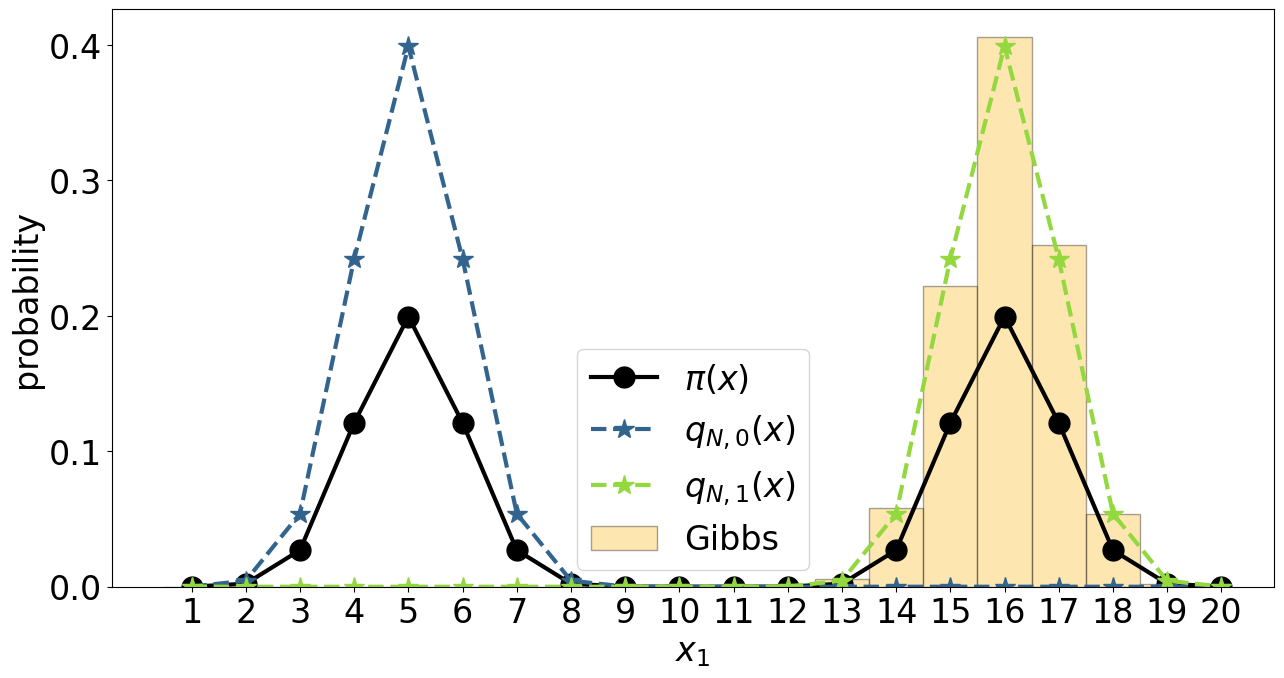

In [17]:
ttx=np.arange(0,20)
plt.plot(ttx+0.5,np.sum(prbs/np.sum(prbs),axis=1),c="black", label=r'$\pi(x)$',lw=3,ms=15,marker='o')
plt.plot(ttx+0.5,np.sum(myqvar0/np.sum(myqvar0),axis=1),c='#32648EFF', label=r'$q_{N,0}(x)$',lw=3,ls='dashed',ms=15,marker='*')
plt.plot(ttx+0.5,np.sum(myqvar1/np.sum(myqvar1),axis=1),c='#94D840FF', label=r'$q_{N,1}(x)$',lw=3,ls='dashed',ms=15,marker='*')
plt.hist(gibbs_samples[0,:],density=True,bins=np.arange(0,20),
         alpha=0.35, label='Gibbs', color="#FBB91FFF",ec='black')
plt.legend()
plt.xlabel(r'$x_1$')
plt.xticks(ticks=np.arange(0,20)+0.5,labels=np.arange(1,21))
plt.ylabel('probability')

### KL-optimal weighting

In [18]:
###############################
###############################
# variational family settings #
###############################
###############################

N=100 # number of steps in qN
xi=np.pi/16
lq0 = lambda x : lqN(x,np.random.rand(2,40),N,lq0_0,lp,xi)
lq1 = lambda x : lqN(x,np.random.rand(2,40),N,lq0_1,lp,xi)
def lq(x,w):
    exp1=lq0(x)+np.log(w)
    exp2=lq1(x)+np.log1p(-w)
    m=np.maximum(exp1,exp2)
    return m+np.log(np.exp(exp1-m)+np.exp(exp2-m))


# init x grid and fixed densities
x=np.zeros((2,40),dtype=int)
x[0,:20]=np.arange(0,20)
x[0,20:]=np.arange(0,20)
x[1,20:]=np.ones(20,dtype=int)
lq0_fixed=lq0(x)
lq1_fixed=lq1(x)

In [19]:
######################
######################
#    optimization    #
######################
######################

# optimization settings
np.random.seed(2023)
max_iter=10
gamma=1e1
w=np.random.rand()
print('Initial w: '+str(w))
print()
print('Iter  |          w          |   gradient')

for t in range(max_iter):
    #print(str(t+1)+'/'+str(max_iter),end='\r')
    gradient=np.sum((np.exp(lq0_fixed)-np.exp(lq1_fixed))*(lq(x,w)-lp(x)))
    w=w-gradient*gamma/np.sqrt(t+1)
    w=min(1-1e-16,max(1e-16,w)) # constrain to (0,1)
    print('  '+str(t+1)+'   | '+str(w)+'  | '+str(gradient))
# end for

Initial w: 0.32198830399196776

Iter  |          w          |   gradient
  1   | 0.39645312489796586  | -0.00744648209059981
  2   | 0.4261703673149584  | -0.004202652726243983
  3   | 0.4433461286566432  | -0.00297492913024755
  4   | 0.4547257535868797  | -0.002275924986047312
  5   | 0.4628468888300592  | -0.0018159410458218617
  6   | 0.4689251608609024  | -0.0014888664993396306
  7   | 0.47362929090135764  | -0.0012445958221952713
  8   | 0.47736213053204446  | -0.0010558064863762096
  9   | 0.48038257362959114  | -0.000906132929264003
  10   | 0.48286527436403504  | -0.0007850989069415615


In [20]:
weighted_q=np.exp(lq(x,w))
myqvar=np.zeros((20,2))
myqvar[:,0]=weighted_q[20:]
myqvar[:,1]=weighted_q[:20]

Text(0, 0.5, 'probability')

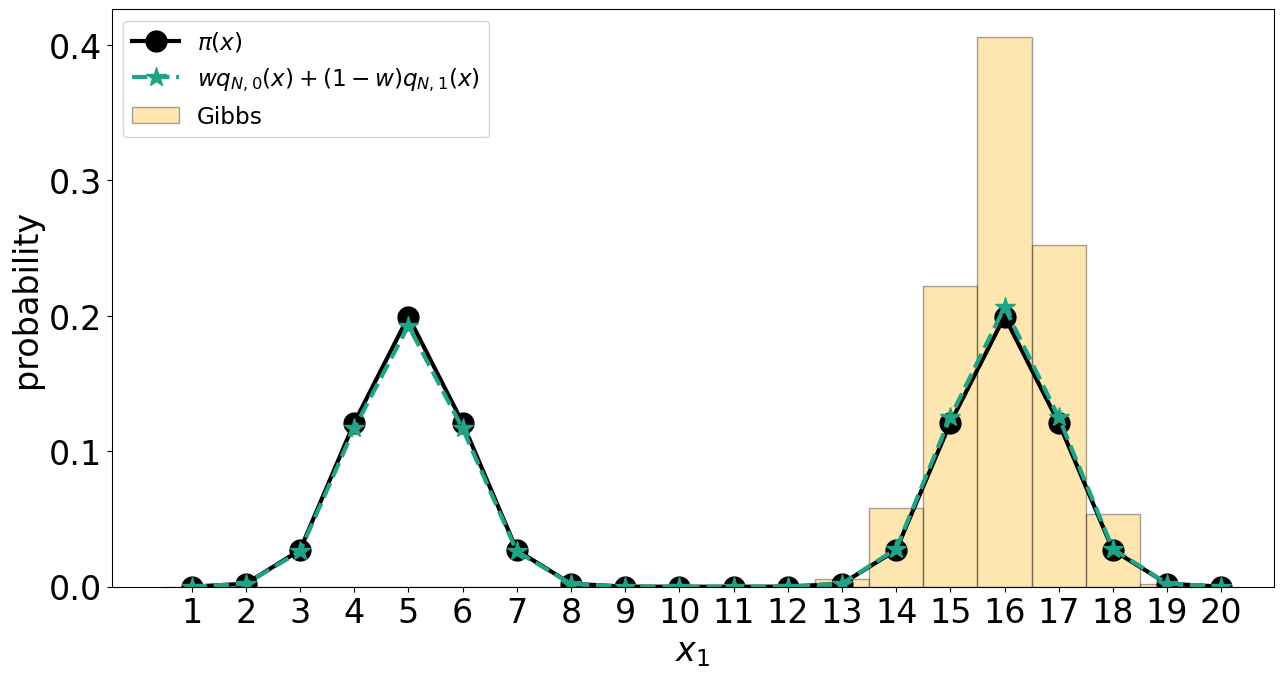

In [21]:
ttx=np.arange(0,20)
plt.plot(ttx+0.5,np.sum(prbs/np.sum(prbs),axis=1),c="black", label=r'$\pi(x)$',lw=3,ms=15,marker='o')
plt.plot(ttx+0.5,np.sum(myqvar/np.sum(myqvar),axis=1),c='#20A386FF', 
         label=r'$wq_{N,0}(x)+(1-w)q_{N,1}(x)$',lw=3,ls='dashed',ms=15,marker='*')
plt.hist(gibbs_samples[0,:],density=True,bins=np.arange(0,20),
         alpha=0.35, label='Gibbs', color="#FBB91FFF",ec='black')
plt.legend(fontsize='x-small')
plt.xlabel(r'$x_1$')
plt.xticks(ticks=np.arange(0,20)+0.5,labels=np.arange(1,21))
plt.ylabel('probability')

In [22]:
# optimal weight density
opt_weighted_q=np.exp(lq(x,0.5))
wstar_qvar=np.zeros((20,2))
wstar_qvar[:,0]=opt_weighted_q[20:]
wstar_qvar[:,1]=opt_weighted_q[:20]

In [23]:
gibbs_density=plt.hist2d(gibbs_samples[0,:],gibbs_samples[1,:],density=True,
                         bins=[np.arange(0,21),np.arange(0,3)],
                         alpha=0.35, label='Gibbs', color="#FBB91FFF",ec='black')[0]
plt.clf()
gibbs_density[gibbs_density<1e-32]=1e-64
elbo_qstar=elbo_exact(np.log(wstar_qvar/np.sum(wstar_qvar)),np.log(prbs))
elbo_qN=elbo_exact(np.log(myqvar/np.sum(myqvar)),np.log(prbs))
elbo_gibbs=elbo_exact(np.log(gibbs_density),np.log(prbs))
print('ELBO(q*||π)='+str(elbo_qstar))
print('ELBO(qN||π)='+str(elbo_qN))
print('ELBO(qGibbs||π)='+str(elbo_gibbs))

ELBO(q*||π)=-2.417727712317125e-11
ELBO(qN||π)=-0.000587314209127829
ELBO(qGibbs||π)=-0.695766523256893


<Figure size 1500x750 with 0 Axes>